# Topic modelling of "programme updates" from ERP newsletter 

For this small dataset I will use non-negative matrix factorisation (NMF) - this is an unsupervised learning technique - falls under the broad umbrella of dimensionality reduction - it decomposes the document-term matrix (V) into two other matrices - 1) 1) document-topic matrix (W) that shows how much each topic appears in each document and 2) a topic-term matric (H) that shows how important each word is to each topic 

The input into a NMF should be a CountVectoriser or a TfidfVectoriser because they do a better job of emphasising important words


Typcially start with two topics and increase by 1 until you figure out the best number of topics 

For NMF TfidfVectorisers tend to work better because 
**Goal: Find the main themes in the data**

for NMF the key preprocessing steps are lowercase, remove stopwords and lemmatise 


# Imports and Data

In [133]:
import pandas as pd
import numpy as np

import re

import spacy 

from sklearn.decomposition import NMF 
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
data_df = pd.read_csv("/workspaces/erp_programme_updates/data/updates_with_project_people.csv")

In [4]:
data_df.head()

,id,newsletter_number,date,link,domain,organisation,text,project,key_person,year
0,237938bb-bac2-4977-8b83-b12f02c37478,2,2023-07-16,https://theconversation.com/poorer-pupils-do-worse-at-school-heres-how-to-reduce-the-attainment-gap-205535,theconversation.com,conversation,"Poorer pupils do worse at school – here's how to reduce the attainment gap Stephen Gorard writes for The Conversation on closing the attainment gap, specifically by looking at 'spread(ing) out the most disadvantaged students between schools' and better calibrating the funding to follow the most disadvantaged pupils.",Recruitment and retention of ethnic minority teachers,Stephen Gorard,2023
1,e1f9ff04-4b3a-48da-b7db-82a12c2eb364,2,2023-07-16,https://www.tes.com/magazine/leadership/staff-management/headteacher-recruitment-crisis-applications,www.tes.com,tes,A three-part series on leadership from Toby Greany and team on TES: Part 1: Headteacher recruitment crisis: 5 tips for action,Sustainable school leadership,Toby Greany,2023
2,a414d421-d953-4300-9fdd-f7b8e081912d,3,2023-07-20,https://blogs.ucl.ac.uk/ioe/2023/06/27/looking-at-teacher-recruitment-and-retention-in-a-new-light,blogs.ucl.ac.uk,ucl_blog,"Teacher recruitment, retention and development - rethinking policy and practice priorities seminar – 3 July 2023 Inaugural event in the 'What Matters in education?' series Blog post on the topic - Looking at teacher recruitment and retention in a new light",Education Research Programme,NaN,2023
3,a6c9957e-6707-426c-831e-a5709b4152e3,3,2023-07-20,https://www.bera.ac.uk/media/teaching-for-digital-citizenship-may2023,www.bera.ac.uk,bera,Teaching for Digital Citizenship Delphi conference View the recording of David Lundie's event (held on May 22). BERA membership required to access. https://www.bera.ac.uk/media/teaching-for-digital-citizenship-may2023,Teaching for digital citizenship,David Lundie,2023
4,1d1ad500-8555-4988-8d4a-51a5a3d18566,3,2023-07-20,https://childrens-participation.org/,childrens-participation.org,childrens_participation_in_schools,My corona*: listening to children in corona times Resource shared via Sarah Chicken's website - https://childrens-participation.org/ This research paper brings together three of the young journalists who worked on The Corona Times Journal to reflect on their experiences of being involved in the project. https://www.tandfonline.com/doi/epdf/10.1080/13642987.2022.2061954?needAccess=true&role=button,Embedding children's participation rights in Wales,Sarah Chicken,2023


In [5]:
data_df.columns

Index(['id', 'newsletter_number', 'date', 'link', 'domain', 'organisation',
       'text', 'project', 'key_person', 'year'],
      dtype='object')

In [6]:
df = data_df[["id", "text"]].copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      125 non-null    object
 1   text    125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


# Names to Remove

In [8]:
name_variations = {
    "Toby Greany": ["Toby Greany", "Greany", "Toby"],
    "Alison Porter": ["Alison Porter", "Porter", "Alison"],
    "Sarah Chicken": ["Sarah Chicken", "Chicken", "Sarah"],
    "Robert Klassen": ["Robert Mark Klassen", "Robert Klassen", "R. M. Klassen", "Robert M. Klassen", "Klassen", "Robert"],
    "David Lundie": ["David Lundie", "Lundie", "David"],
    "Stephanie Ainsworth": ["Stephanie Ainsworth", "Ainsworth", "Stephanie"],
    "Stephen Gorard": ["Stephen Gorard", "Gorard", "Stephen"],
    "John Gordon": ["John Gordon", "Gordon", "John"],
    "Rebecca Eynon": ["Rebecca Eynon", "Eynon", "Rebecca"],
    "Gemma Moss": ["Gemma Moss", "Moss", "Gemma"],
    "Beng Huat See": ["Beng Huat See", "Huat See", "Beng Huat", "Beng", "Huat"],
    "Carrie Adamson": ["Carrie Adamson", "Adamson", "Carrie"],
    "Laura Hakimi": ["Laura Hakimi", "Hakimi", "Laura"],
    "Jacqui Lewis": ["Jacqui Lewis", "Lewis", "Jacqui"],
    "Louise Couceiro": ["Louise Couceiro", "Couceiro", "Louise"],
    "Jacky Tyrie": ["Jacky Tyrie", "Tyrie", "Jacky"],
    "Ted Palenski": ["Ted Palenski", "Palenski", "Ted"],
    "Rachel France": ["Rachel France", "France", "Rachel"],
    "Thomas Perry": ["Thomas Perry", "Perry", "Thomas"],
    "Rebecca Snell": ["Rebecca Snell", "Rebecca", "Snell"],
    "Hui Wang": ["Hui Wang", "Hui", "Wang"],
    "Sophe Thompsonlee": ["Sophie", "Thompsonlee"],
    "Jade Parnell": ["Jade", "Parnell"],
}

# Clean Text - lower and replace - using pandas

In [9]:
#lowercase

In [10]:
df["text_clean"] = df["text"].str.lower()

In [11]:
#remove square brackets
df["text_clean"] = df["text_clean"].str.replace(r'\[.*?\]', '', regex=True)

In [12]:
#remove all punctuation 
df["text_clean"] = df["text_clean"].str.replace(r'[^\w\s]', '', regex=True)

In [13]:
#remove urls 
df["text_clean"] = df["text_clean"].str.replace(r'http\S+|www\.\S+', '', regex=True)

In [14]:
#remove numbers 
df["text_clean"] = df["text_clean"].str.replace(r'\d+', '', regex=True)

In [15]:
#remove special characters 
df["text_clean"] = df["text_clean"].str.replace(r'[^\x00-\x7F]+', ' ', regex=True)

In [16]:
#remove html tags
df["text_clean"] = df["text_clean"].str.replace(r'<.*?>', '', regex=True)

In [17]:
#whitespace cleanup 
df["text_clean"] = df["text_clean"].str.replace(r'\s+', ' ', regex=True).str.strip()

In [18]:
df.head()

,id,text,text_clean
0,237938bb-bac2-4977-8b83-b12f02c37478,"Poorer pupils do worse at school – here's how to reduce the attainment gap Stephen Gorard writes for The Conversation on closing the attainment gap, specifically by looking at 'spread(ing) out the most disadvantaged students between schools' and better calibrating the funding to follow the most disadvantaged pupils.",poorer pupils do worse at school heres how to reduce the attainment gap stephen gorard writes for the conversation on closing the attainment gap specifically by looking at spreading out the most disadvantaged students between schools and better calibrating the funding to follow the most disadvantaged pupils
1,e1f9ff04-4b3a-48da-b7db-82a12c2eb364,A three-part series on leadership from Toby Greany and team on TES: Part 1: Headteacher recruitment crisis: 5 tips for action,a threepart series on leadership from toby greany and team on tes part headteacher recruitment crisis tips for action
2,a414d421-d953-4300-9fdd-f7b8e081912d,"Teacher recruitment, retention and development - rethinking policy and practice priorities seminar – 3 July 2023 Inaugural event in the 'What Matters in education?' series Blog post on the topic - Looking at teacher recruitment and retention in a new light",teacher recruitment retention and development rethinking policy and practice priorities seminar july inaugural event in the what matters in education series blog post on the topic looking at teacher recruitment and retention in a new light
3,a6c9957e-6707-426c-831e-a5709b4152e3,Teaching for Digital Citizenship Delphi conference View the recording of David Lundie's event (held on May 22). BERA membership required to access. https://www.bera.ac.uk/media/teaching-for-digital-citizenship-may2023,teaching for digital citizenship delphi conference view the recording of david lundies event held on may bera membership required to access
4,1d1ad500-8555-4988-8d4a-51a5a3d18566,My corona*: listening to children in corona times Resource shared via Sarah Chicken's website - https://childrens-participation.org/ This research paper brings together three of the young journalists who worked on The Corona Times Journal to reflect on their experiences of being involved in the project. https://www.tandfonline.com/doi/epdf/10.1080/13642987.2022.2061954?needAccess=true&role=button,my corona listening to children in corona times resource shared via sarah chickens website this research paper brings together three of the young journalists who worked on the corona times journal to reflect on their experiences of being involved in the project


In [19]:
#remove names 

In [20]:
def remove_names(text):
    """Remove all name variations from the text"""
    text_lower = text.lower()
    
    for person, variations in name_variations.items():
        for variation in variations:
            # Create pattern that matches the variation as a whole word
            pattern = r'\b' + re.escape(variation.lower()) + r'\b'
            text_lower = re.sub(pattern, '', text_lower)
    
    # Clean up extra whitespace that might result from removals
    text_lower = re.sub(r'\s+', ' ', text_lower).strip()
    return text_lower

In [21]:
df["text_clean"] = df["text_clean"].apply(remove_names)

In [22]:
df.head()

,id,text,text_clean
0,237938bb-bac2-4977-8b83-b12f02c37478,"Poorer pupils do worse at school – here's how to reduce the attainment gap Stephen Gorard writes for The Conversation on closing the attainment gap, specifically by looking at 'spread(ing) out the most disadvantaged students between schools' and better calibrating the funding to follow the most disadvantaged pupils.",poorer pupils do worse at school heres how to reduce the attainment gap writes for the conversation on closing the attainment gap specifically by looking at spreading out the most disadvantaged students between schools and better calibrating the funding to follow the most disadvantaged pupils
1,e1f9ff04-4b3a-48da-b7db-82a12c2eb364,A three-part series on leadership from Toby Greany and team on TES: Part 1: Headteacher recruitment crisis: 5 tips for action,a threepart series on leadership from and team on tes part headteacher recruitment crisis tips for action
2,a414d421-d953-4300-9fdd-f7b8e081912d,"Teacher recruitment, retention and development - rethinking policy and practice priorities seminar – 3 July 2023 Inaugural event in the 'What Matters in education?' series Blog post on the topic - Looking at teacher recruitment and retention in a new light",teacher recruitment retention and development rethinking policy and practice priorities seminar july inaugural event in the what matters in education series blog post on the topic looking at teacher recruitment and retention in a new light
3,a6c9957e-6707-426c-831e-a5709b4152e3,Teaching for Digital Citizenship Delphi conference View the recording of David Lundie's event (held on May 22). BERA membership required to access. https://www.bera.ac.uk/media/teaching-for-digital-citizenship-may2023,teaching for digital citizenship delphi conference view the recording of lundies event held on may bera membership required to access
4,1d1ad500-8555-4988-8d4a-51a5a3d18566,My corona*: listening to children in corona times Resource shared via Sarah Chicken's website - https://childrens-participation.org/ This research paper brings together three of the young journalists who worked on The Corona Times Journal to reflect on their experiences of being involved in the project. https://www.tandfonline.com/doi/epdf/10.1080/13642987.2022.2061954?needAccess=true&role=button,my corona listening to children in corona times resource shared via chickens website this research paper brings together three of the young journalists who worked on the corona times journal to reflect on their experiences of being involved in the project


# Text preprocessing with spacy 

In [23]:
#specify the language 
nlp = spacy.load('en_core_web_sm')

In [24]:
#remove stopwords (words that don't have significant meaning) 

In [25]:
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return " ".join(tokens)

In [26]:
df["text_no_stop"] = df["text_clean"].apply(remove_stopwords)

In [27]:
df.head()

,id,text,text_clean,text_no_stop
0,237938bb-bac2-4977-8b83-b12f02c37478,"Poorer pupils do worse at school – here's how to reduce the attainment gap Stephen Gorard writes for The Conversation on closing the attainment gap, specifically by looking at 'spread(ing) out the most disadvantaged students between schools' and better calibrating the funding to follow the most disadvantaged pupils.",poorer pupils do worse at school heres how to reduce the attainment gap writes for the conversation on closing the attainment gap specifically by looking at spreading out the most disadvantaged students between schools and better calibrating the funding to follow the most disadvantaged pupils,poorer pupils worse school heres reduce attainment gap writes conversation closing attainment gap specifically looking spreading disadvantaged students schools better calibrating funding follow disadvantaged pupils
1,e1f9ff04-4b3a-48da-b7db-82a12c2eb364,A three-part series on leadership from Toby Greany and team on TES: Part 1: Headteacher recruitment crisis: 5 tips for action,a threepart series on leadership from and team on tes part headteacher recruitment crisis tips for action,threepart series leadership team tes headteacher recruitment crisis tips action
2,a414d421-d953-4300-9fdd-f7b8e081912d,"Teacher recruitment, retention and development - rethinking policy and practice priorities seminar – 3 July 2023 Inaugural event in the 'What Matters in education?' series Blog post on the topic - Looking at teacher recruitment and retention in a new light",teacher recruitment retention and development rethinking policy and practice priorities seminar july inaugural event in the what matters in education series blog post on the topic looking at teacher recruitment and retention in a new light,teacher recruitment retention development rethinking policy practice priorities seminar july inaugural event matters education series blog post topic looking teacher recruitment retention new light
3,a6c9957e-6707-426c-831e-a5709b4152e3,Teaching for Digital Citizenship Delphi conference View the recording of David Lundie's event (held on May 22). BERA membership required to access. https://www.bera.ac.uk/media/teaching-for-digital-citizenship-may2023,teaching for digital citizenship delphi conference view the recording of lundies event held on may bera membership required to access,teaching digital citizenship delphi conference view recording lundies event held bera membership required access
4,1d1ad500-8555-4988-8d4a-51a5a3d18566,My corona*: listening to children in corona times Resource shared via Sarah Chicken's website - https://childrens-participation.org/ This research paper brings together three of the young journalists who worked on The Corona Times Journal to reflect on their experiences of being involved in the project. https://www.tandfonline.com/doi/epdf/10.1080/13642987.2022.2061954?needAccess=true&role=button,my corona listening to children in corona times resource shared via chickens website this research paper brings together three of the young journalists who worked on the corona times journal to reflect on their experiences of being involved in the project,corona listening children corona times resource shared chickens website research paper brings young journalists worked corona times journal reflect experiences involved project


In [28]:
#lemmatisation (reduces words to their base form - optional but recommended) 

In [29]:
def preprocess_for_nmf(text):
    doc = nlp(text)
    allowed_pos = {"NOUN", "ADJ", "PROPN"}  # words that carry topic meaning
    
    lemmas = [
        token.lemma_
        for token in doc
        if token.pos_ in allowed_pos
        and not token.is_stop
        and not token.is_punct
    ]
    
    return " ".join(lemmas)

In [30]:
df["text_preprocessed"] = df["text_no_stop"].apply(preprocess_for_nmf)

In [31]:
df.head()

,id,text,text_clean,text_no_stop,text_preprocessed
0,237938bb-bac2-4977-8b83-b12f02c37478,"Poorer pupils do worse at school – here's how to reduce the attainment gap Stephen Gorard writes for The Conversation on closing the attainment gap, specifically by looking at 'spread(ing) out the most disadvantaged students between schools' and better calibrating the funding to follow the most disadvantaged pupils.",poorer pupils do worse at school heres how to reduce the attainment gap writes for the conversation on closing the attainment gap specifically by looking at spreading out the most disadvantaged students between schools and better calibrating the funding to follow the most disadvantaged pupils,poorer pupils worse school heres reduce attainment gap writes conversation closing attainment gap specifically looking spreading disadvantaged students schools better calibrating funding follow disadvantaged pupils,poor pupil bad school here attainment gap conversation attainment gap disadvantaged student school funding disadvantaged pupil
1,e1f9ff04-4b3a-48da-b7db-82a12c2eb364,A three-part series on leadership from Toby Greany and team on TES: Part 1: Headteacher recruitment crisis: 5 tips for action,a threepart series on leadership from and team on tes part headteacher recruitment crisis tips for action,threepart series leadership team tes headteacher recruitment crisis tips action,threepart series leadership team headteacher recruitment crisis tip action
2,a414d421-d953-4300-9fdd-f7b8e081912d,"Teacher recruitment, retention and development - rethinking policy and practice priorities seminar – 3 July 2023 Inaugural event in the 'What Matters in education?' series Blog post on the topic - Looking at teacher recruitment and retention in a new light",teacher recruitment retention and development rethinking policy and practice priorities seminar july inaugural event in the what matters in education series blog post on the topic looking at teacher recruitment and retention in a new light,teacher recruitment retention development rethinking policy practice priorities seminar july inaugural event matters education series blog post topic looking teacher recruitment retention new light,teacher recruitment retention development policy practice priority seminar july inaugural event education series blog post topic teacher recruitment retention new light
3,a6c9957e-6707-426c-831e-a5709b4152e3,Teaching for Digital Citizenship Delphi conference View the recording of David Lundie's event (held on May 22). BERA membership required to access. https://www.bera.ac.uk/media/teaching-for-digital-citizenship-may2023,teaching for digital citizenship delphi conference view the recording of lundies event held on may bera membership required to access,teaching digital citizenship delphi conference view recording lundies event held bera membership required access,digital citizenship delphi conference view recording lundie event bera membership access
4,1d1ad500-8555-4988-8d4a-51a5a3d18566,My corona*: listening to children in corona times Resource shared via Sarah Chicken's website - https://childrens-participation.org/ This research paper brings together three of the young journalists who worked on The Corona Times Journal to reflect on their experiences of being involved in the project. https://www.tandfonline.com/doi/epdf/10.1080/13642987.2022.2061954?needAccess=true&role=button,my corona listening to children in corona times resource shared via chickens website this research paper brings together three of the young journalists who worked on the corona times journal to reflect on their experiences of being involved in the project,corona listening children corona times resource shared chickens website research paper brings young journalists worked corona times journal reflect experiences involved project,corona child corona times resource chicken website research paper young journalist corona times journal experience project


In [32]:
#check if there are any rows with fewer than three words 
df["word_count"] = df["text_preprocessed"].str.split().str.len()
short_rows = df[df["word_count"] < 3]
short_rows

,id,text,text_clean,text_no_stop,text_preprocessed,word_count


# TFIDFVectoriser
Vectorisation is the idea of converting text data into numeric data - so that future data analyss and ML techniques can be applied 
TFIDF is an alternative to the word count calculation in DTM - it emphasises important words by reducing the impact of common words 

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_df=.8)
tfidf = vectorizer.fit_transform(df["text_preprocessed"])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,able,absence,absence question,academic,academy,access,agency,agency technology,ai,al,...,worthwhile esrc,year,year primary,year priority,yiyang,young,young child,young children,young people,zoom
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.406851,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.266153,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
121,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
122,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.335731,0.000000,0.0,0.0,0.0,0.0


# NMF Model

#### Explored 1-10 topics and 7 seems to be the correct number of topics for this dataset 

In [99]:
nmf = NMF(n_components=7, random_state=42) 

W = nmf.fit_transform(tfidf) #maps documents to topics
H = nmf.components_ #topics to terms 

In [124]:
# For each document, find the topic with the highest weight
df["topic_id"] = np.argmax(W, axis=1)

df["topic_id"].head()
df.columns

Index(['id', 'text', 'text_clean', 'text_no_stop', 'text_preprocessed',
       'word_count', 'topic_id'],
      dtype='object')

# Display Topics


In [100]:
H.shape

(7, 635)

In [101]:
H[1] #shows weights asssociated with a topic - the bigger the weight the more relevant a topic

array([0.00000000e+00, 4.20107012e-02, 4.55997056e-02, 3.21655199e-02,
       1.47873743e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.66788017e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.38086338e-02, 0.00000000e+00,
       0.00000000e+00, 2.62404998e-03, 1.53631381e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.42477842e-01,
       6.57117510e-01, 2.85190609e-02, 2.85190609e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [109]:
#create a function to display topics 
def display_topics(H, num_words=20): 
    for topic_num, topic_array in enumerate(H):
        top_features = topic_array.argsort()[::-1][:num_words]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_features]
        print("Topic", topic_num+1, ":", top_words)

In [110]:
display_topics(H)

Topic 1 : ['education', 'research', 'policy', 'panel', 'pm', 'special', 'issue', 'programme', 'practice', 'discussion', 'pupil', 'ucl', 'special issue', 'panel discussion', 'speaker', 'community', 'pm pm', 'bera', 'priority', 'university']
Topic 2 : ['note', 'briefing note', 'briefing', 'knowledge exchange', 'exchange', 'knowledge', 'education briefing', 'exchange education', 'education', 'series', 'series briefing', 'note education', 'education series', 'researcher', 'policy', 'way', 'priority', 'international', 'education seminar', 'challenge']
Topic 3 : ['children', 'right', 'participative', 'participative right', 'children participative', 'young children', 'young', 'participation school', 'children participation', 'participation', 'school', 'policy', 'wale', 'right school', 'curriculum', 'project', 'finding project', 'legislation', 'legislation policy', 'vlog']
Topic 4 : ['teacher', 'recruitment', 'teacher recruitment', 'recruitment retention', 'retention', 'paper', 'career', 'cris

In [116]:
#apply labels 
topic_labels = {
    1: "Education Research & Policy Events",
    2: "Knowledge Exchange & Briefings",
    3: "Children’s Rights & Participation",
    4: "Teacher Recruitment & Retention",
    5: "Digital Citizenship & Technology",
    6: "School Leadership & Sustainability",
    7: "Early Years, Primary & Pedagogy",
}

In [125]:
# Map numeric topic to human-readable label
df["topic_label"] = df["topic_id"].map(topic_labels)

In [126]:
df["topic_label"].value_counts(normalize=True)

topic_label
Digital Citizenship & Technology      0.247525
Children’s Rights & Participation     0.217822
Teacher Recruitment & Retention       0.207921
Knowledge Exchange & Briefings        0.148515
Education Research & Policy Events    0.099010
School Leadership & Sustainability    0.079208
Name: proportion, dtype: float64

# Show example documents per topic

In [128]:
def show_example_docs_per_topic(df, W, num_docs=3):
    """
    Print a few example documents for each topic, ordered by topic weight.
    """
    for topic_idx in range(W.shape[1]):
        print(f"\n========== Topic {topic_idx} ==========")
        # sort documents by their weight on this topic
        topic_doc_indices = np.argsort(W[:, topic_idx])[::-1][:num_docs]
        
        for rank, doc_idx in enumerate(topic_doc_indices, start=1):
            weight = W[doc_idx, topic_idx]
            print(f"\n-- Topic {topic_idx}, example {rank} (weight={weight:.3f}) --")
            print(df.loc[doc_idx, "text"])  # original text (not cleaned)

show_example_docs_per_topic(df, W, num_docs=3)


========== Topic 0 ==========

-- Topic 0, example 1 (weight=0.313) --
Pupil absence: Questions for policy, for research and in practice 22 January 2024, 5.30pm – 7.00pm 'What matters in education?' panel discussion Speakers: Lindsey Macmillan, Professor of Economics and Director of the Centre for Education Policy and Equalising Opportunities at UCL Institute of Education, Faculty of Education and Society Dame Rachel de Souza, Children's Commissioner for England Ellie Costello, Director at Square Peg Douglas Hutchison, Executive Director of Education at Glasgow City Council Pupil absence post COVID has risen, yet what the precise causes are and how they can best be remedied remains uncertain. The evidence given to the Education Select Committee Inquiry into this topic set out a number of interlinking factors that need taking into consideration if the situation is to improve. In this panel discussion, speakers will draw on their knowledge of the issues, based on research, practice and 

# Visalisations 

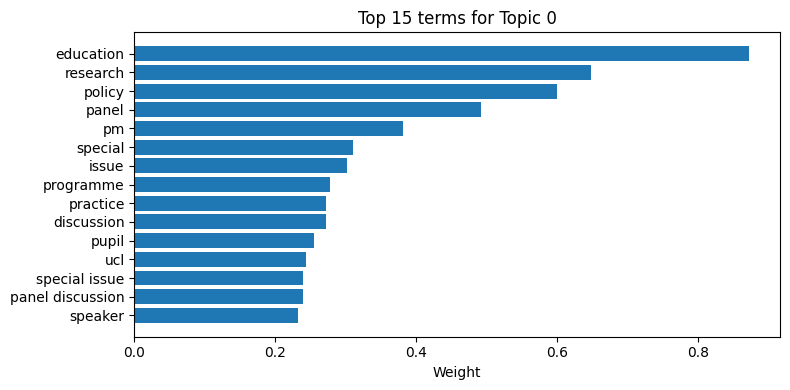

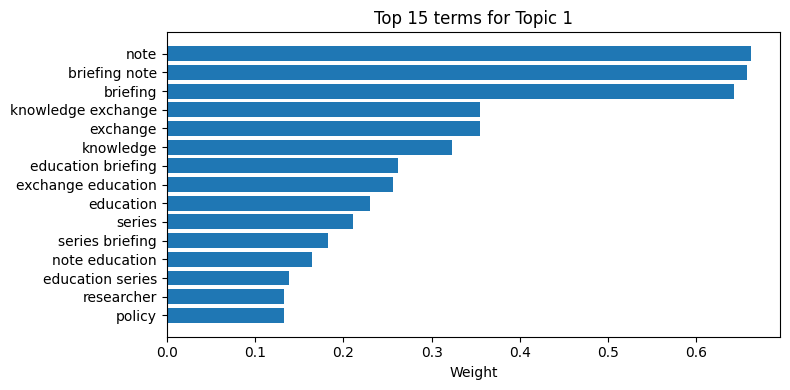

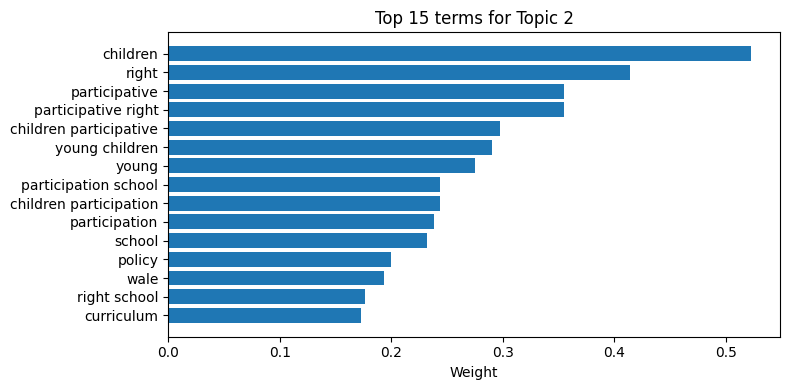

In [134]:
#top words per topic 

def plot_top_terms_per_topic(H, vectorizer, topic_idx, top_n=15):
    feature_names = vectorizer.get_feature_names_out()
    topic = H[topic_idx]
    top_indices = topic.argsort()[::-1][:top_n]
    top_weights = topic[top_indices]
    top_terms = [feature_names[i] for i in top_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(range(top_n), top_weights[::-1])
    plt.yticks(range(top_n), top_terms[::-1])
    plt.xlabel("Weight")
    plt.title(f"Top {top_n} terms for Topic {topic_idx}")
    plt.tight_layout()
    plt.show()

# Example: plot topics 0–2
for t in range(min(3, H.shape[0])):
    plot_top_terms_per_topic(H, vectorizer, topic_idx=t, top_n=15)

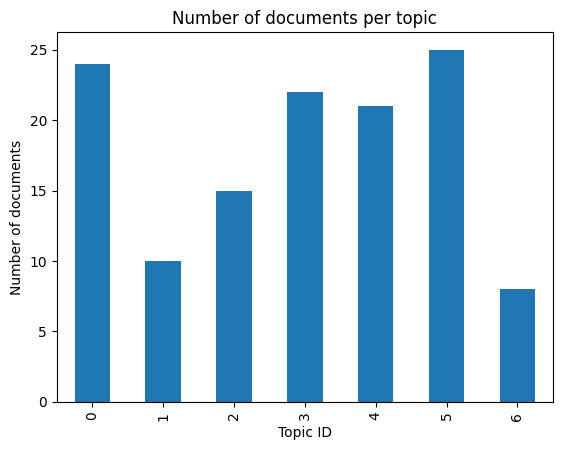

In [135]:
#topic distribution across documents 

topic_counts = df["topic_id"].value_counts().sort_index()

plt.figure()
topic_counts.plot(kind="bar")
plt.xlabel("Topic ID")
plt.ylabel("Number of documents")
plt.title("Number of documents per topic")
plt.show()


### Preprocessing and Hyperparameter Choices

- **Lowercasing, punctuation, numbers, and HTML removal**: standard steps to reduce noise in small corpora.
- **Name removal**: project-specific – avoids topics dominated by individual researchers’ names.
- **spaCy lemmatisation + POS filtering (NOUN, ADJ, PROPN)**: focuses on content words that carry topical meaning.
- **Stopword removal**: removes high-frequency function words that are unlikely to define topics.

**Vectoriser parameters**

- `ngram_range=(1, 2)`: includes unigrams and bigrams, allowing phrases like *teacher education* or *professional learning* to emerge as meaningful units.
- `min_df=2`: ignores terms that appear in only one document (too idiosyncratic for this small dataset).
- `max_df=0.8`: removes terms that appear in more than 80% of documents (too generic).
- `TfidfVectorizer`: TF–IDF emphasises discriminative terms, which tends to work well with NMF for topic modelling.

These choices were tested across topic numbers 2–10; we selected **k = 7** based on reconstruction error, silhouette scores, and the interpretability of topics when inspecting top terms and example documents.


# SAVE FILE 

In [138]:
cols_to_keep = [
    "id",
    "text",
    "text_preprocessed",
     "topic_id",
    "topic_label",
]

In [139]:
doc_topics_df = df[cols_to_keep].copy()

In [141]:
save_path = "/workspaces/erp_programme_updates/data/programme_updates_topics.csv"
doc_topics_df.to_csv(save_path, index=False)

save_path

'/workspaces/erp_programme_updates/data/programme_updates_topics.csv'